# 1.1 Data Visualization


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import ndimage
import time 
import geopandas as gpd
from shapely.geometry import Point, Polygon, box

import folium
from folium import plugins

import math
from math import radians, cos, sin, asin, sqrt

df = pd.read_csv('../data/cases_train.csv')
df_location = pd.read_csv('../data/location.csv')

# Showing NaN values for each attribute

In [2]:
print('Missing values for cases_train')
for name, values in df.iteritems():
    print(f'{name} is missing {len(df[df[name].isnull()])} values') 

Missing values for cases_train
age is missing 209265 values
sex is missing 207084 values
province is missing 4106 values
country is missing 18 values
latitude is missing 2 values
longitude is missing 2 values
date_confirmation is missing 288 values
additional_information is missing 344912 values
source is missing 128478 values
outcome is missing 0 values


In [3]:
print('Missing values for location')
for name, values in df_location.iteritems():
    print(f'{name} is missing {len(df_location[df_location[name].isnull()])} values')

Missing values for location
Province_State is missing 168 values
Country_Region is missing 0 values
Last_Update is missing 0 values
Lat is missing 80 values
Long_ is missing 80 values
Confirmed is missing 0 values
Deaths is missing 0 values
Recovered is missing 0 values
Active is missing 2 values
Combined_Key is missing 0 values
Incidence_Rate is missing 80 values
Case-Fatality_Ratio is missing 48 values


# Visualizing Age 

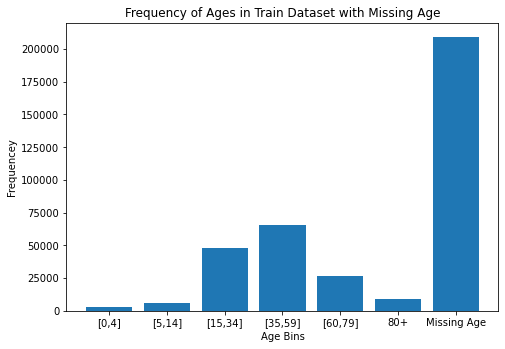

In [4]:
ageBins = ['[0,4]','[5,14]','[15,34]','[35,59]','[60,79]','80+', 'Missing Age']
trainFrequency = [2777, 5889, 48221, 65555,26643,9083,209468]
# df = pd.DataFrame({'frequency': frequency}, index=index)
# ax = df.plot.bar(rot=0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ageBins,trainFrequency)
ax.set_ylabel('Frequencey')
ax.set_xlabel('Age Bins')
plt.title('Frequency of Ages in Train Dataset with Missing Age')
plt.show()

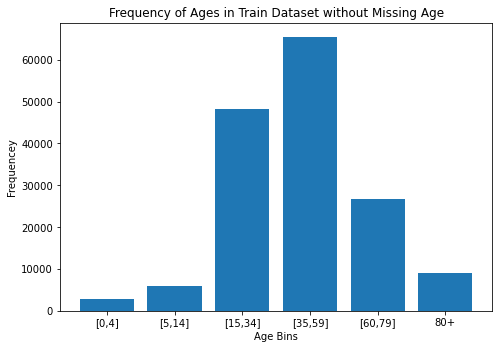

In [5]:
ageBins = ['[0,4]','[5,14]','[15,34]','[35,59]','[60,79]','80+']
trainFrequency = [2777, 5889, 48221, 65555,26643,9083]
# df = pd.DataFrame({'frequency': frequency}, index=index)
# ax = df.plot.bar(rot=0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ageBins,trainFrequency)
ax.set_ylabel('Frequencey')
ax.set_xlabel('Age Bins')
plt.title('Frequency of Ages in Train Dataset without Missing Age')
plt.show()

# Visualization of sex attribute

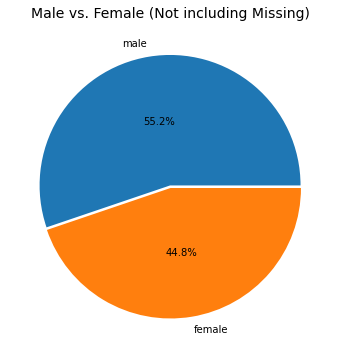

In [6]:
#Take a look at only rows where a sex was provided
sexdf = df[~df['sex'].isna()]
sex = sexdf['sex'].value_counts() #df with no missing vals for sex

pie, ax = plt.subplots(figsize=[10,6])
labels = sex.keys()
plt.pie(x=sex, autopct="%.1f%%", explode=[0.01]*len(sex), labels=labels, pctdistance=0.5)
plt.title("Male vs. Female (Not including Missing)", fontsize=14);

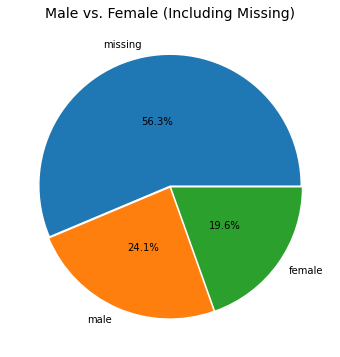

In [7]:
#Exploring sex
df['sex'] = df['sex'].fillna('missing')

sex = df['sex'].value_counts()

pie, ax = plt.subplots(figsize=[10,6])
labels = sex.keys()
plt.pie(x=sex, autopct="%.1f%%", explode=[0.01]*len(sex), labels=labels, pctdistance=0.5)
plt.title("Male vs. Female (Including Missing)", fontsize=14);

# Visualizing Countries

In [8]:
#top 10 countries
countries = df['country'].value_counts().head(10) 
countries

India             212411
Peru               57305
Germany            33009
Philippines        11521
Colombia           11464
Argentina           7948
Mexico              5149
Belgium             5145
United Kingdom      4289
Czech Republic      3381
Name: country, dtype: int64

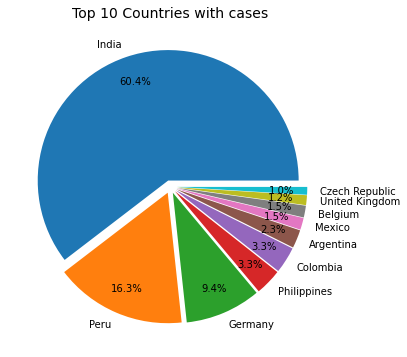

In [9]:
#Exploring Top 10 countries
pie, ax = plt.subplots(figsize=[10,6])
labels = countries.keys()
plt.pie(x=countries, autopct="%.1f%%", explode=[0.05]*len(countries), labels=labels, pctdistance=0.8)
plt.title("Top 10 Countries with cases", fontsize=14);

In [10]:
#Aggregating countries not in top 10 into category called other
country_list = list(countries.keys())

def fix_values(row):
        if row['country'] not in country_list:
            row['country'] = 'Other'
        return row 

df_other = df.apply(fix_values, axis=1)
countries_other = df_other['country'].value_counts()

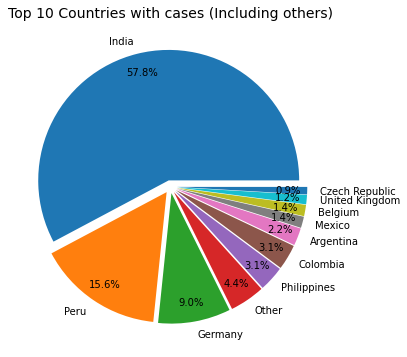

In [11]:
pie, ax = plt.subplots(figsize=[10,6])
labels = countries_other.keys()
plt.pie(x=countries_other, autopct="%.1f%%", explode=[0.05]*len(countries_other), labels=labels, pctdistance=0.85)
plt.title("Top 10 Countries with cases (Including others)", fontsize=14);

# Visualizing dates

In [12]:

#Cleaning dates that have a range by taking the earlier date

def split_date(datestr):
    if datestr == np.nan:
        return np.nan
    elif '-' in str(datestr):
        
        div = datestr.split('-')[0] #take the first date
#         print(f'the string was {datestr} the split is {div}')
        return div
    else:
        return datestr


df['date_confirmation'] = df['date_confirmation'].apply(split_date)
meandate = pd.to_datetime(df.date_confirmation).mean().date()
the_date = str(meandate.day) + '.' + str(meandate.month) + '.' + str(meandate.year)
df['date_confirmation'] = df['date_confirmation'].fillna(the_date) # fill date with mean date
df['date_confirmation'] = pd.to_datetime(df['date_confirmation'].apply(lambda x: str.strip(x)))

In [13]:
#Same thing but doing it on my dataframe with top n countries

df_other['date_confirmation'] = df_other['date_confirmation'].apply(split_date)
meandate = pd.to_datetime(df_other.date_confirmation).mean().date()
the_date = str(meandate.day) + '.' + str(meandate.month) + '.' + str(meandate.year)
df_other['date_confirmation'] = df_other['date_confirmation'].fillna(the_date) # fill date with mean date
df_other['date_confirmation'] = pd.to_datetime(df_other['date_confirmation'].apply(lambda x: str.strip(x)))

In [14]:
country_list = df_other['country'].value_counts().head().keys()

In [15]:
df_lineplot = df_other.apply(fix_values, axis=1)
#pivot so that the values in the column of countries become columns themselves
df_lineplot = df_lineplot.pivot_table(values='outcome', index='date_confirmation',columns='country',aggfunc='count').fillna(0)
df_lineplot = df_lineplot.join(df['date_confirmation'].value_counts()).rename({'date_confirmation':'World'},axis=1) #add the world

reorder = ['World', 'Germany', 'India', 'Peru', 'Philippines', 'Other']
df_lineplot = df_lineplot[reorder]

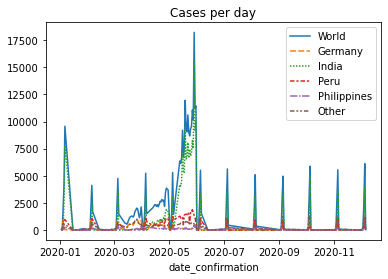

In [16]:
cases_per_day = sns.lineplot(data=df_lineplot).set(title='Cases per day')

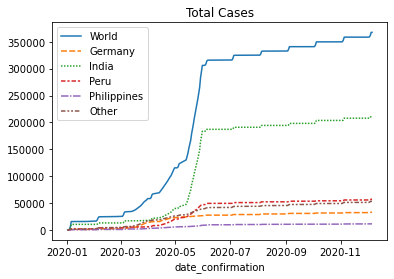

In [17]:
total_cases = sns.lineplot(data=df_lineplot.cumsum()).set(title='Total Cases')

# Visualizing Outcomes

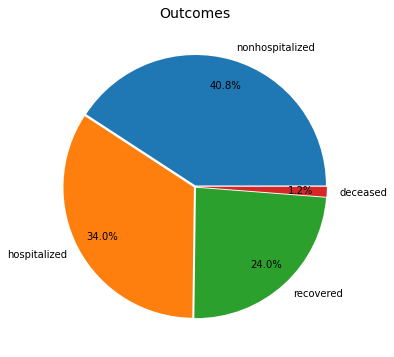

In [18]:
outcomes = df['outcome'].value_counts()
pie, ax = plt.subplots(figsize=[10,6])
labels = outcomes.keys()
plt.pie(x=outcomes, autopct="%.1f%%", explode=[0.01]*len(outcomes), labels=labels, pctdistance=0.8)
plt.title("Outcomes", fontsize=14);

In [19]:
df.rename(columns={'latitude':'Lat','longitude':'Long'},inplace=True)
df_location.rename(columns={'Lat':'Lat','Long_':'Long'},inplace=True)
crs={'init': u'epsg:4269'}

crs = {'init': 'epsg:4269'}
counties_gdf = gpd.read_file("../data/shapefiles/us/cb_2016_us_county_5m.shp")
counties_gdf.crs
continental_us = box(-124.848974, 24.396308, 66.885444, 49.384358)

In [20]:
usa = df_location[df_location['Country_Region']=='US']
usa.dropna(subset=['Lat','Long'],inplace=True)
us_gdf = gpd.GeoDataFrame(usa,crs=crs,geometry=gpd.points_from_xy(usa.Long,usa.Lat))
us_gdf = us_gdf[us_gdf.is_valid==True]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
clipusdgf = us_gdf[us_gdf.geometry.intersects(continental_us)]

Text(0.5, 1.0, 'Chloropleth Map of Case-Fatality_Ratio USA Location Data')

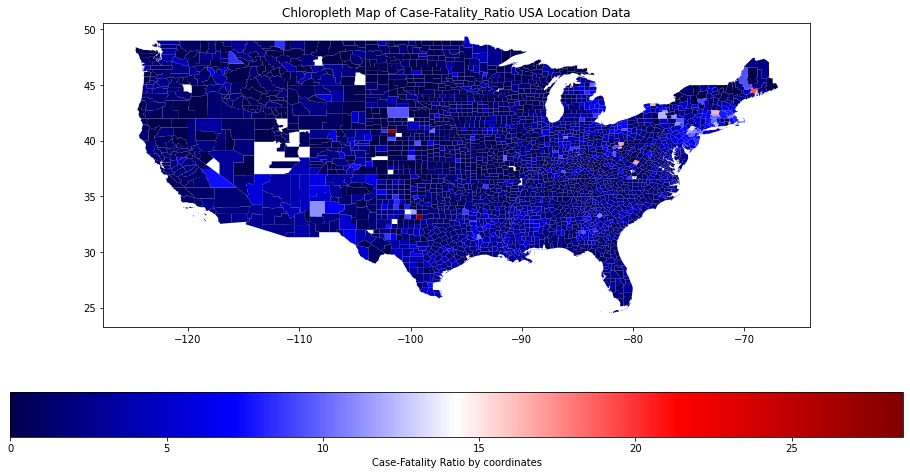

In [22]:
mergcounty = gpd.sjoin(counties_gdf,us_gdf,how='inner')
clipusdgf = mergcounty[mergcounty.geometry.intersects(continental_us)]

clipusdgf.sort_values('Case-Fatality_Ratio',ascending=True).plot(column='Case-Fatality_Ratio',figsize=(16,8),alpha=1,legend=True,cmap='seismic',legend_kwds={'label':'Case-Fatality Ratio by coordinates','orientation':"horizontal"})
plt.title('Chloropleth Map of Case-Fatality_Ratio USA Location Data')

Text(0.5, 1.0, 'Chloropleth Map of Actives cases in the USA Location Data')

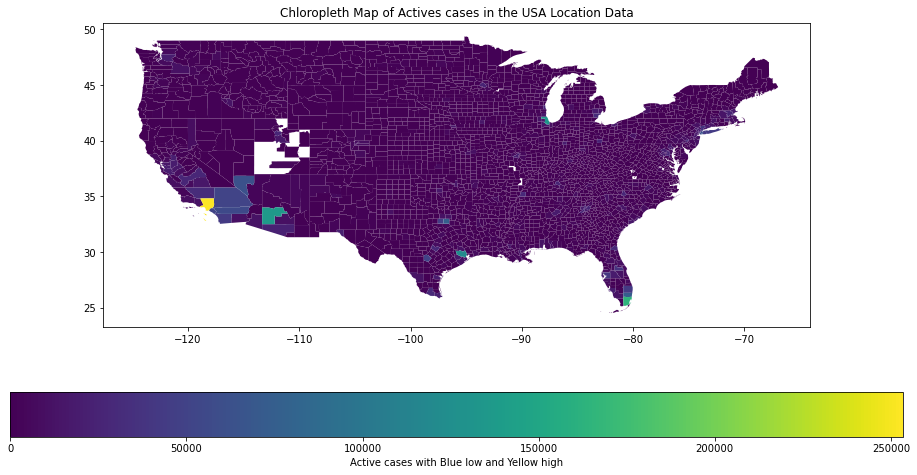

In [23]:
clipusdgf.sort_values('Active',ascending=True).plot(column='Active',figsize=(16,8),legend=True,legend_kwds={'label':'Active cases with Blue low and Yellow high','orientation':"horizontal"})
plt.title("Chloropleth Map of Actives cases in the USA Location Data")

Text(0.5, 1.0, 'Chloropleth Map of Case-Fatality_Ratio USA Location Data')

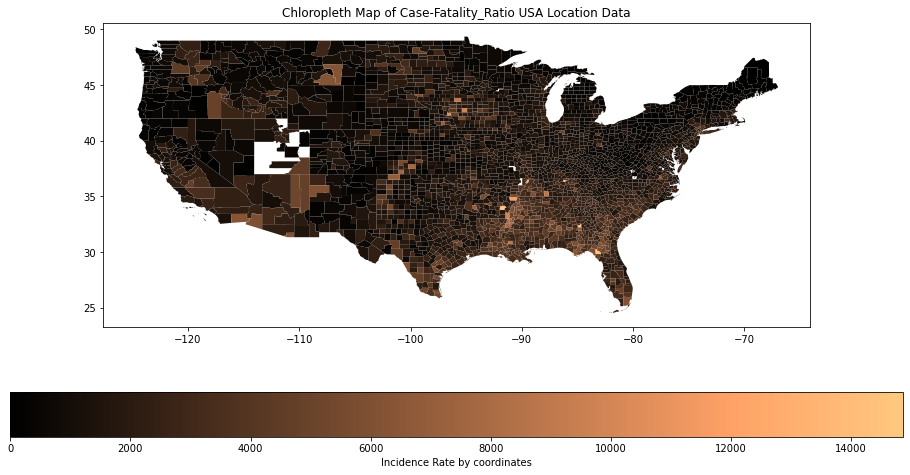

In [24]:

clipusdgf.sort_values('Incidence_Rate',ascending=True).plot(column='Incidence_Rate',figsize=(16,8),alpha=1,legend=True,cmap='copper',legend_kwds={'label':'Incidence Rate by coordinates','orientation':"horizontal"})
plt.title('Chloropleth Map of Case-Fatality_Ratio USA Location Data')